In [274]:
# Run first time only (doesn't matter much)
#%pip install pandas numpy matplotlib scipy statsmodels linearmodels arch stargazer

In [275]:
import pandas as pd
import numpy as np
import scipy.stats as stat

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import sys
sys.path.append("../src")


In [279]:
# Adjusing Parameters
#tickers = ['VIC', 'VCB', 'VHM', 'CTG', 'BID', 'TCB', 'VPB', 'HPG']
tickers = ['VIC', 'VHM', 'ACB', 'DGC', 'VRE']
start_date = '2025-06-01'
end_date = '2025-12-24'
interval_select = '1d'

In [277]:
from vnstock import Listing, Quote

# Define Listing for accessibility
listing = Listing(source="VCI") 
VN30 = listing.symbols_by_group("VN30")

parent = []
for stock in VN30:
    quote = Quote(symbol= stock, source="VCI")
    df = quote.history(start=start_date, end=end_date, interval=interval_select)
    df['ticker'] = stock
    df['time'] = pd.to_datetime(df['time'])
    df['m_volume'] = df['volume'] * df['close']
    df['ret'] = df['close'].pct_change()
    df['log_ret'] = np.log(df['close']).diff()

    parent.append(df)

panel = pd.concat(parent, ignore_index=False)
panel

,time,open,high,low,close,volume,ticker,m_volume,ret,log_ret
0,2025-05-27,21.60,21.60,21.40,21.45,9336007,ACB,2.002574e+08,NaN,NaN
1,2025-05-28,21.50,21.55,21.35,21.40,7876823,ACB,1.685640e+08,-0.002331,-0.002334
2,2025-05-29,21.45,21.50,21.30,21.30,9082800,ACB,1.934636e+08,-0.004673,-0.004684
3,2025-05-30,21.30,21.35,21.10,21.10,7933184,ACB,1.673902e+08,-0.009390,-0.009434
4,2025-06-02,21.10,21.20,21.00,21.10,8200572,ACB,1.730321e+08,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
145,2025-12-18,29.95,30.55,29.55,30.35,6326300,VRE,1.920032e+08,0.021886,0.021649
146,2025-12-19,30.35,31.80,30.20,31.70,10546100,VRE,3.343114e+08,0.044481,0.043520
147,2025-12-22,31.90,33.00,31.00,33.00,9656000,VRE,3.186480e+08,0.041009,0.040191
148,2025-12-23,32.70,35.00,32.40,34.25,14877500,VRE,5.095544e+08,0.037879,0.037179


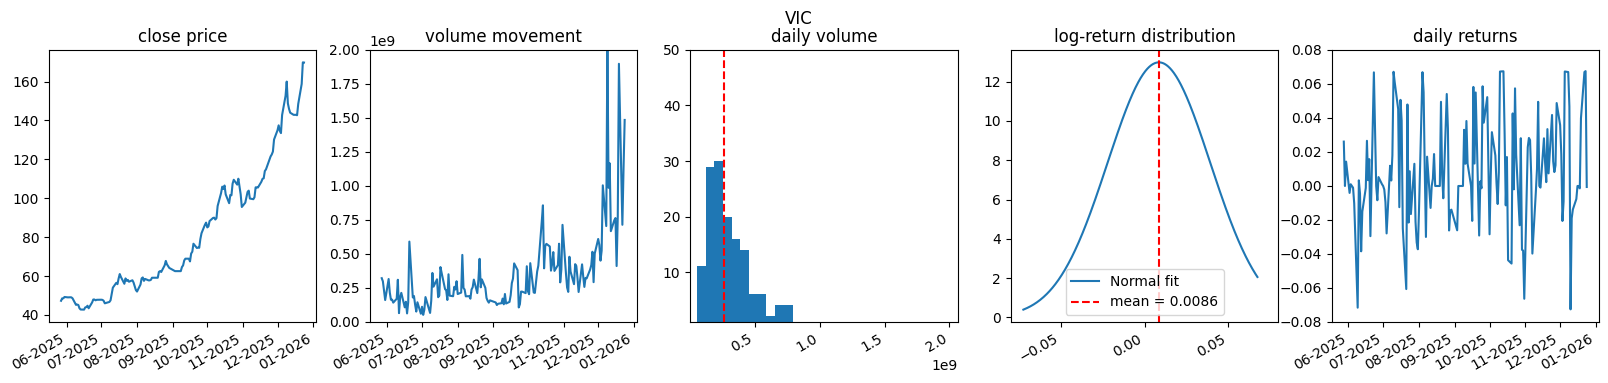

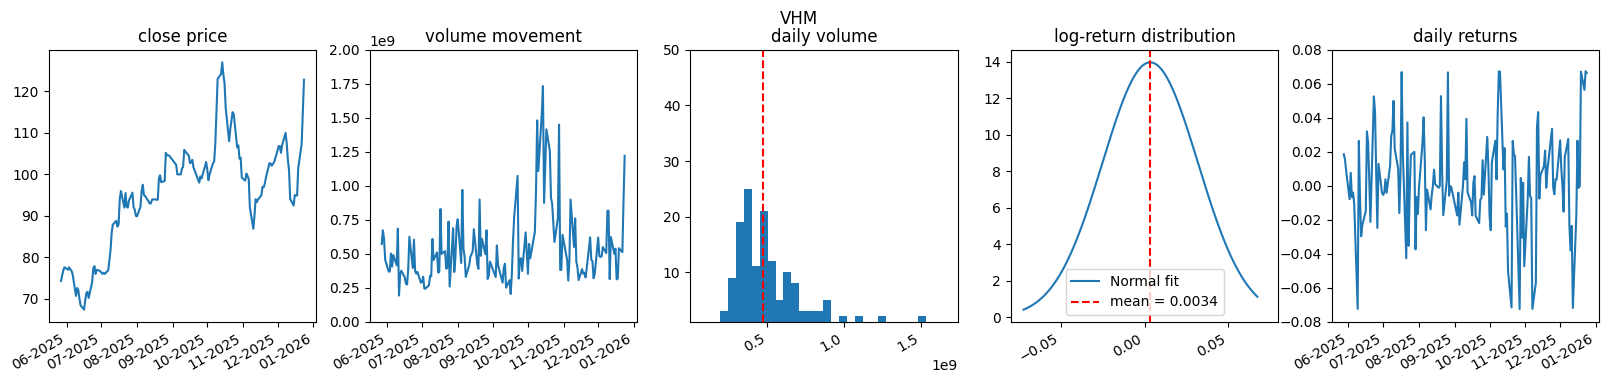

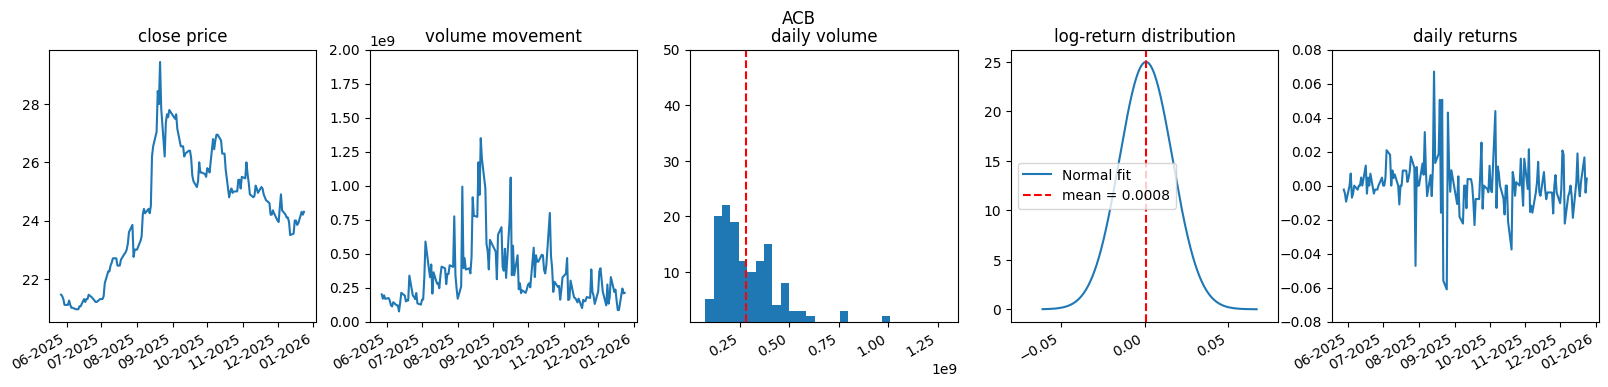

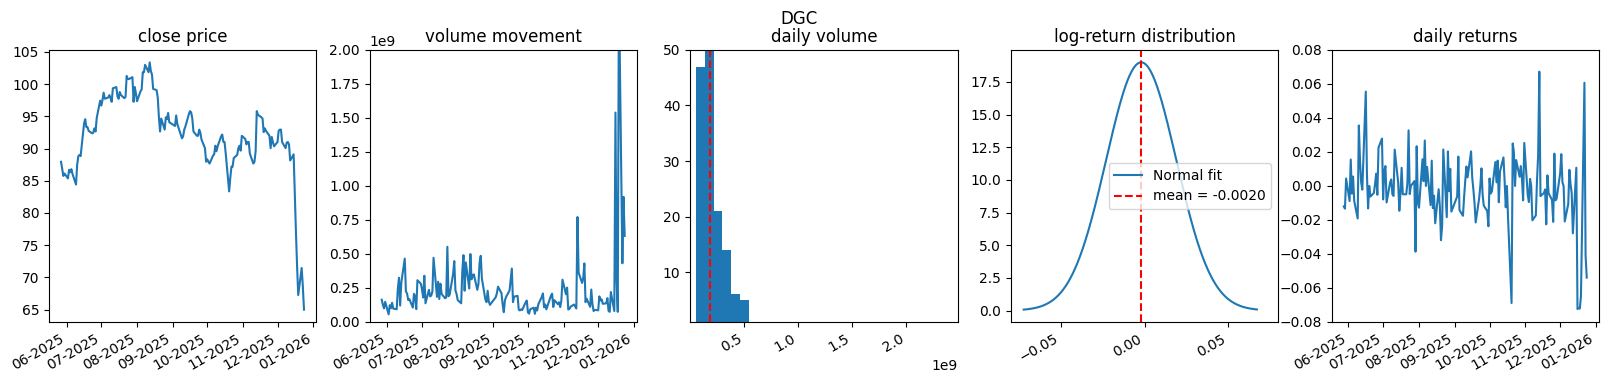

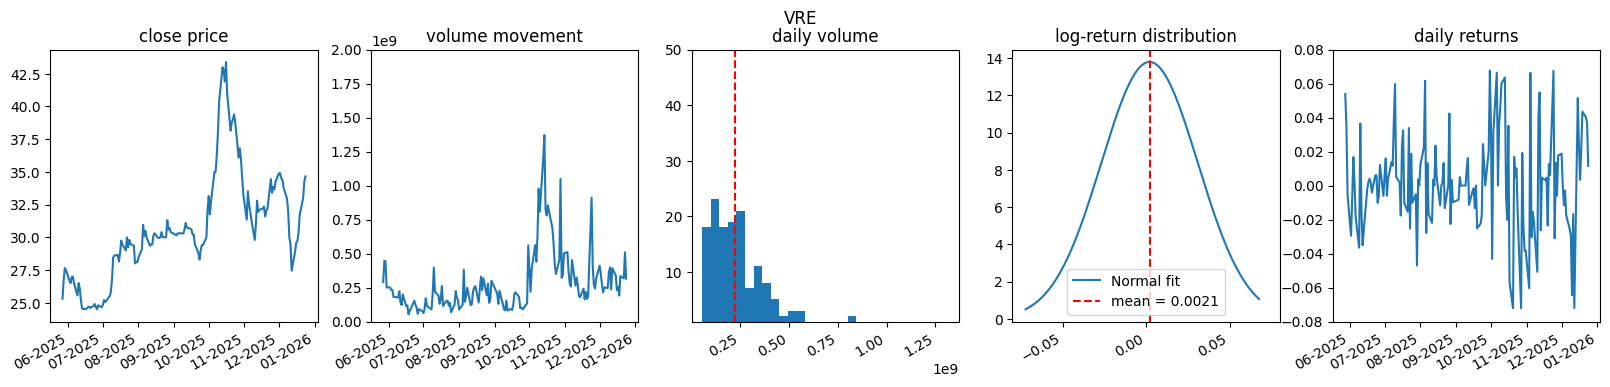

In [290]:
date_format = mdates.DateFormatter("%m-%Y")

for stock in tickers:
    df = panel[panel['ticker'] == stock].copy()
    data = (
        df['log_ret']
        .replace([np.inf, -np.inf], np.nan)
        .dropna()
    )

    median_vol = df['m_volume'].median()

    fig, axs = plt.subplots(1, 5, figsize=(20,4))
    # Plots
    axs[0].plot(df['time'], df['close'])
    axs[1].plot(df['time'], df['m_volume'])
    axs[2].hist(df['m_volume'], 30)
    axs[4].plot(df['time'], df['log_ret'])

    if data.empty:
        axs[3].text(0.5, 0.5, 'no log-return data', transform=axs[3].transAxes,
                    ha='center', va='center')
    else:
        mu, sigma = stat.norm.fit(data)
        x = np.linspace(data.min(), data.max(), 500)
        y = stat.norm.pdf(x, mu, sigma)
        axs[3].plot(x, y, label="Normal fit")
        axs[3].axvline(mu, color='r', linestyle='--', label=f"mean = {mu:.4f}")
        axs[3].legend()

    axs[2].axvline(median_vol, color='r', linestyle='--', label=f"median = {median_vol:.4f}")

    # Title
    axs[1].set_title("volume movement")
    axs[0].set_title("close price")
    axs[2].set_title("daily volume")
    axs[3].set_title("log-return distribution")
    axs[4].set_title("daily returns")

    axs[1].set_ylim(0, 2*(10**9))
    
    axs[2].set_xlim(10**0, df['m_volume'].max())
    axs[2].set_ylim(1, 50)
    axs[3].set_xlim(-0.08, 0.08)
    axs[4].set_ylim(-0.08, 0.08)


    # Set X Axis to date format
    axs[0].xaxis.set_major_formatter(date_format)
    axs[1].xaxis.set_major_formatter(date_format)
    axs[4].xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    fig.suptitle(f"{stock}")
    plt.show()
